# Exercise

[*Lesson Page*](https://ds.codeup.com/10-anomaly-detection/4-detecting-timeseries-anomalies/)

**File name:** `time_series_anomaly_detection.py` or `time_series_anomaly_detection.ipynb`

## Time series + EMA
Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

In [1]:
###############################################################################
### pthon imports                                                           ###
###############################################################################

import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

In [2]:
###############################################################################
### local imports                                                           ###
###############################################################################

#from env import host, user, password
from debug import local_settings, timeifdebug, timeargsifdebug, frame_splain
import acquire as acq


### Get Source Data

***Import and view data***
(Initial view of text file suggests space-deliminited)

In [3]:
df = pd.read_csv('anonymized-curriculum-access.txt', header=None, sep=' ')#.rename(columns={0:'data'})
df.sample(10)

,0,1,2,3,4,5
178275,2019-01-11,09:38:43,spring/fundamentals/repositories,263,26.0,97.105.19.58
249701,2019-04-22,09:28:30,toc,327,29.0,97.105.19.58
365236,2019-10-07,09:27:23,javascript-i/introduction/working-with-data-ty...,502,51.0,97.105.19.58
71095,2018-06-13,14:41:40,javascript-i/functions,197,24.0,97.105.19.61
319544,2019-08-12,15:35:07,9-timeseries/exercises,404,28.0,97.105.19.58
157078,2018-11-16,10:22:54,spring/extra-features/error-pages,256,25.0,107.77.219.67
244316,2019-04-14,09:03:47,toc,211,28.0,173.174.210.2
320527,2019-08-13,16:12:28,study-session-with-ryan,447,33.0,97.105.19.58
122129,2018-09-11,09:05:19,/,225,25.0,97.105.19.58
146805,2018-10-26,23:02:09,appendix/extra-challenges/memory-game,258,25.0,69.166.71.6


***infer column names based on data***

In [4]:
df.rename(columns={0:'ts_date', 1:'ts_time', 2:'path', 3:'unknown_1', 4:'unknown_2', 5: 'ip'}, inplace=True)
df.sample(10)

,ts_date,ts_time,path,unknown_1,unknown_2,ip
170379,2018-12-13,13:55:21,java-iii/jdbc,277,26.0,97.105.19.58
333604,2019-08-27,12:01:45,1-fundamentals/1.1-intro-to-data-science,11,28.0,97.105.19.58
306000,2019-07-23,15:54:23,appendix/git/working-in-teams,415,32.0,97.105.19.58
168313,2018-12-10,16:50:11,spring/fundamentals/views,310,27.0,99.98.36.168
145281,2018-10-24,12:25:47,jquery/essential-methods/attributes-and-css,272,26.0,97.105.19.58
177502,2019-01-08,21:11:52,spring/fundamentals/services,275,26.0,76.204.31.63
124637,2018-09-14,15:00:33,javascript-ii,228,25.0,205.251.148.146
114783,2018-08-27,16:14:57,mysql/database-design,186,24.0,97.105.19.58
323362,2019-08-16,10:08:21,toc,436,33.0,97.105.19.58
167066,2018-12-07,12:06:27,java-iii,53,28.0,97.105.19.58


In [5]:
frame_splain(df, splain=True)

DATAFRAME SHAPE:
(399195, 6)

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399195 entries, 0 to 399194
Data columns (total 6 columns):
ts_date      399195 non-null object
ts_time      399195 non-null object
path         399195 non-null object
unknown_1    399195 non-null int64
unknown_2    372441 non-null float64
ip           399195 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 18.3+ MB
None

DATAFRAME DESCRIPTION:
              count        mean         std  min    25%    50%    75%    max
unknown_1  399195.0  268.794667  147.587312  1.0  157.0  288.0  392.0  543.0
unknown_2  372441.0   26.912649    7.846146  1.0   23.0   27.0   31.0   52.0

DATAFRAME HEAD:
      ts_date   ts_time                                 path  unknown_1  \
0  2018-01-26  09:55:03                                    /          1   
1  2018-01-26  09:56:02                              java-ii          1   
2  2018-01-26  09:56:05  java-ii/object-oriented-programming   

***Make datetime index using `date` and `time` values***

Make copy for future use, drop original columns

In [6]:
df['timestamp'] = df.ts_date + ' ' + df.ts_time
df.timestamp=pd.to_datetime(df.timestamp, format='%Y-%m-%d %H:%M:%S')
df['idx'] = df.timestamp
df.set_index('idx', inplace=True)
df.drop(columns=['ts_date','ts_time'])
display(df.sample(10))

,ts_date,ts_time,path,unknown_1,unknown_2,ip,timestamp
idx,,,,,,,
2019-09-05 15:29:06,2019-09-05,15:29:06,javascript-ii,315,26.0,97.105.19.58,2019-09-05 15:29:06
2019-03-04 11:54:00,2019-03-04,11:54:00,7._Clustering,11,28.0,97.105.19.58,2019-03-04 11:54:00
2018-08-17 13:48:12,2018-08-17,13:48:12,slides/servlets,189,24.0,97.105.19.58,2018-08-17 13:48:12
2018-06-13 08:03:09,2018-06-13,08:03:09,html-css/elements,204,24.0,97.105.19.61,2018-06-13 08:03:09
2019-02-26 22:25:59,2019-02-26,22:25:59,javascript-i/arrays,324,29.0,99.98.32.165,2019-02-26 22:25:59
2019-08-13 13:42:32,2019-08-13,13:42:32,mysql/tables,414,32.0,97.105.19.58,2019-08-13 13:42:32
2019-09-19 14:50:47,2019-09-19,14:50:47,java-i/strings,53,14.0,97.105.19.58,2019-09-19 14:50:47
2018-07-31 15:13:36,2018-07-31,15:13:36,slides/file_io,53,14.0,97.105.19.58,2018-07-31 15:13:36
2019-07-15 16:40:54,2019-07-15,16:40:54,spring/fundamentals/views,384,31.0,97.105.19.58,2019-07-15 16:40:54


In [7]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 399195 entries, 2018-01-26 09:55:03 to 2019-11-19 10:07:45
Data columns (total 7 columns):
ts_date      399195 non-null object
ts_time      399195 non-null object
path         399195 non-null object
unknown_1    399195 non-null int64
unknown_2    372441 non-null float64
ip           399195 non-null object
timestamp    399195 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 24.4+ MB


None

,unknown_1,unknown_2
count,399195.000000,372441.000000
mean,268.794667,26.912649
std,147.587312,7.846146
min,1.000000,1.000000
25%,157.000000,23.000000
50%,288.000000,27.000000
75%,392.000000,31.000000
max,543.000000,52.000000


***Get values for columns***

In [90]:
df.timestamp.describe()

count                  399195
unique                 384859
top       2019-03-03 22:52:07
freq                       30
first     2018-01-26 09:55:03
last      2019-11-19 10:07:45
Name: timestamp, dtype: object

In [20]:
df.path.value_counts()

/                                                                            20564
javascript-i                                                                  8140
search/search_index.json                                                      7005
toc                                                                           6679
html-css                                                                      6143
java-iii                                                                      6003
spring                                                                        5761
jquery                                                                        5501
java-ii                                                                       5386
mysql                                                                         5103
java-i                                                                        5039
javascript-ii                                                                 5024
mysq

***`path` appears to have folder structure in place, will separate in later step***

In [115]:
df.isna().sum()

ts_date          0
ts_time          0
path             0
unknown_1        0
unknown_2    26754
ip               0
timestamp        0
lvls             0
path0            0
path1            0
path2            0
path3            0
path4            0
path5            0
path6            0
dtype: int64

In [11]:
df.unknown_1.value_counts()

53     8236
64     8008
11     8004
344    5279
1      4266
314    3233
423    2995
323    2846
354    2821
211    2625
418    2598
127    2563
410    2398
277    2367
347    2318
325    2248
363    2237
433    2217
337    2183
186    2180
274    2136
315    2130
416    2103
368    2063
304    2061
272    2008
197    1993
275    1900
264    1898
269    1894
       ... 
137      10
279      10
84       10
141       9
95        9
388       8
107       8
104       8
401       7
115       6
152       5
399       5
71        5
169       5
82        5
62        4
216       4
85        4
246       4
348       3
177       3
89        3
176       3
81        3
97        2
66        1
461       1
163       1
165       1
212       1
Name: unknown_1, Length: 543, dtype: int64

In [13]:
df.unknown_2.value_counts()

29.0    35969
24.0    35039
33.0    34433
22.0    28875
23.0    28056
32.0    26801
26.0    26760
25.0    25233
31.0    22665
28.0    20677
27.0    20198
34.0    15519
51.0    10835
14.0     9069
1.0      8877
21.0     7181
17.0     3792
52.0     2896
13.0     2610
8.0      1671
18.0     1603
19.0     1142
16.0      740
15.0      691
7.0       461
12.0      270
11.0      204
2.0        93
6.0        72
9.0         5
4.0         4
Name: unknown_2, dtype: int64

***`unknown_2` appears to be some kind of index value***

In [14]:
df.ip.value_counts()

97.105.19.58       227220
97.105.19.61        61662
192.171.117.210      8127
70.122.40.62         1338
66.69.108.117        1199
173.174.211.206      1019
108.65.244.91        1007
170.248.173.245       997
67.11.157.190         972
66.69.62.219          934
70.118.8.243          876
72.181.104.64         865
170.248.173.247       828
216.1.153.162         823
67.11.215.97          818
76.185.131.226        793
173.173.113.51        779
67.11.239.2           777
99.61.24.168          765
67.10.174.56          739
72.181.98.75          681
45.23.250.16          663
67.10.161.55          651
136.50.18.71          631
76.204.31.63          618
4.16.216.161          610
72.181.110.80         607
170.248.173.246       590
67.10.166.10          578
70.121.163.5          577
                    ...  
72.177.198.47           1
107.77.220.6            1
107.77.221.80           1
174.207.12.44           1
67.11.82.179            1
107.77.100.91           1
99.203.26.111           1
173.239.232.

In [119]:
df['slash']=df.path.str.count('/')
max_slash = df.slash.max()
print('max_slash:', max_slash)
df['newslashes'] = max_slash - df.slash
df['slashes'] = df.newslashes.apply(lambda x: x * '/')
df['pathslash'] = df.path + df.slashes
df['repath']=df.pathslash.str.split('/')
for lvl in range(max_slash+1):
    col_name = 'path' + str(lvl)
    df[col_name] = df.pathslash.apply(lambda x: x.split('/')[lvl])
    
df.drop(columns=['slash','newslashes','slashes','pathslash','repath'], inplace=True)
display(df.sample(10))

max_slash: 7


,ts_date,ts_time,path,unknown_1,unknown_2,ip,timestamp,lvls,path0,path1,path2,path3,path4,path5,path6,path7
idx,,,,,,,,,,,,,,,,
2018-07-24 10:15:19,2018-07-24,10:15:19,javascript-ii,10,21.0,70.120.230.205,2018-07-24 10:15:19,8,javascript-ii,,,,,,,
2018-04-09 02:12:43,2018-04-09,02:12:43,jquery/events,120,23.0,104.190.255.78,2018-04-09 02:12:43,8,jquery,events,,,,,,
2019-09-16 21:03:14,2019-09-16,21:03:14,html-css,314,17.0,173.173.109.203,2019-09-16 21:03:14,8,html-css,,,,,,,
2019-05-24 12:08:34,2019-05-24,12:08:34,/,383,31.0,97.105.19.58,2019-05-24 12:08:34,8,,,,,,,,
2018-02-26 20:29:43,2018-02-26,20:29:43,javascript-ii/es6,7,22.0,72.191.50.176,2018-02-26 20:29:43,8,javascript-ii,es6,,,,,,
2018-01-31 20:13:17,2018-01-31,20:13:17,mysql/group-by,42,21.0,72.181.118.217,2018-01-31 20:13:17,8,mysql,group-by,,,,,,
2019-04-02 13:28:42,2019-04-02,13:28:42,7.1_Overview,397,28.0,97.105.19.58,2019-04-02 13:28:42,8,7.1_Overview,,,,,,,
2018-08-17 15:37:15,2018-08-17,15:37:15,java-iii/deployment-and-dependencies,185,24.0,97.105.19.58,2018-08-17 15:37:15,8,java-iii,deployment-and-dependencies,,,,,,
2018-07-24 09:01:03,2018-07-24,09:01:03,html-css/elements,235,25.0,97.105.19.58,2018-07-24 09:01:03,8,html-css,elements,,,,,,


In [88]:
df.path0.value_counts()

javascript-i                  55152
html-css                      40885
mysql                         39823
jquery                        29903
spring                        28620
java-iii                      25938
java-ii                       23882
                              20564
javascript-ii                 20343
java-i                        19283
appendix                      13760
content                        7805
examples                       7353
search                         7007
slides                         6872
toc                            6679
1-fundamentals                 3120
4-python                       2798
6-regression                   2588
3-sql                          2348
mkdocs                         1909
5-stats                        1855
7-classification               1536
8-clustering                   1163
index.html                     1155
2-storytelling                  944
web-design                      826
9-timeseries                

In [131]:
df.path3.value_counts()

                                      386643
authentication                          1964
flexbox-fundamentals                    1002
gitbook                                  862
css-grid-fundamentals                    786
flexbox-in-practice                      722
images                                   711
intellij-tomcat-configuration            708
css-grid-in-practice                     685
css-grid-intro                           604
authorization                            383
devtools-configuration                   362
seeder                                   255
security-use-cases                       211
pagination                               182
array-splice                             172
hoisting                                 151
application-structure.html               150
environment.html                         117
hello-world-and-other-strings.html        74
db-migrations.html                        66
this                                      64
resource-c

In [110]:
dfunk12 = df.groupby(by=['unknown_1', 'unknown_2'], as_index=False).timestamp.agg(['count', 'min', 'max'])
dfunk.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 516 entries, (1, 8.0) to (543, 33.0)
Data columns (total 3 columns):
count    516 non-null int64
min      516 non-null datetime64[ns]
max      516 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 18.2 KB


In [109]:
dfunk21 = df.groupby(by=['unknown_2', 'unknown_1']).timestamp.agg(['count', 'min', 'max'])
dfunk.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 516 entries, (1, 8.0) to (543, 33.0)
Data columns (total 3 columns):
count    516 non-null int64
min      516 non-null datetime64[ns]
max      516 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 18.2 KB


In [111]:
dfunk12

count                 min                 max
unknown_1 unknown_2                                               
1         8.0         1617 2018-01-26 09:55:03 2018-12-05 08:01:42
          28.0        2649 2018-12-08 18:25:15 2019-11-19 08:38:17
2         22.0        1541 2018-01-26 09:56:24 2018-05-10 18:25:38
3         22.0        1562 2018-01-26 09:56:46 2019-04-06 21:32:32
4         22.0         692 2018-01-26 09:58:26 2018-03-27 14:28:18
5         22.0        1701 2018-01-26 09:59:22 2018-07-19 14:08:20
6         22.0        1408 2018-01-26 10:00:02 2019-03-18 22:13:39
7         22.0        1803 2018-01-26 10:02:02 2019-06-27 14:18:37
8         22.0         483 2018-01-26 10:02:21 2018-03-14 15:46:06
9         22.0         585 2018-01-26 10:02:42 2018-05-11 11:28:51
10        21.0         750 2018-01-26 10:08:22 2019-05-23 12:39:47
11        1.0         2735 2018-01-26 10:14:47 2018-12-06 11:14:11
          28.0        5269 2018-12-07 09:05:02 2019-11-19 10:01:25
12        22.0         729 2018-01-26 10:33:18 2018-11-19 11:02:46
13        22.0          79 2018-01-26 10:33:25 2018-05-02 17:15:29
14        22.0         596 2018-01-26 10:35:08 2018-10-10 17:38:59
15        21.0         296 2018-01-26 10:35:28 2019-11-12 19:27:54
16        21.0         193 2018-01-26 10:35:29 2019-05-23 16:21:57
17        21.0         175 2018-01-26 10:35:35 2018-02-18 12:42:12
18        22.0        1455 2018-01-26 10:39:50 2019-10-22 15:44:16
19        22.0        1518 2018-01-26 10:41:21 2019-10-12 16:52:58
20        22.0         624 2018-01-26 10:44:06 2019-10-08 11:13:40
21        16.0         107 2018-01-26 10:59:02 2018-07-18 14:13:42
22        21.0         199 2018-01-26 11:11:52 2018-02-27 23:23:58
23        22.0         969 2018-01-26 11:14:07 2018-03-09 09:02:49
24        21.0          26 2018-01-26 11:24:17 2018-02-07 11:07:31
25        22.0         451 2018-01-26 11:36:00 2018-03-05 13:21:32
          23.0        1358 2018-03-05 14:22:48 2019-07-15 13:45:06
26        18.0         474 2018-01-26 11:36:27 2019-10-11 23:02:05
27        21.0         482 2018-01-26 11:40:33 2018-07-18 15:32:05
...                    ...                 ...                 ...
515       33.0         233 2019-11-04 09:53:24 2019-11-19 09:54:29
516       52.0          62 2019-11-04 16:03:34 2019-11-19 10:01:50
517       52.0          51 2019-11-04 16:03:35 2019-11-19 08:22:25
518       52.0          69 2019-11-04 16:03:35 2019-11-19 09:01:36
519       52.0         104 2019-11-04 16:03:35 2019-11-19 08:58:54
520       52.0          88 2019-11-04 16:03:35 2019-11-19 09:37:54
521       52.0         189 2019-11-04 16:03:35 2019-11-19 08:57:33
522       52.0         133 2019-11-04 16:03:36 2019-11-19 10:00:33
523       52.0          50 2019-11-04 16:03:36 2019-11-18 16:01:13
524       52.0         328 2019-11-04 16:03:37 2019-11-19 08:25:36
525       52.0         105 2019-11-04 16:03:37 2019-11-18 16:11:09
526       52.0         111 2019-11-04 16:03:38 2019-11-19 10:00:40
527       52.0          85 2019-11-04 16:03:39 2019-11-19 08:03:02
528       52.0         120 2019-11-04 16:03:42 2019-11-19 10:04:08
529       52.0          36 2019-11-04 16:03:42 2019-11-08 10:54:44
530       52.0         109 2019-11-04 16:03:43 2019-11-19 09:13:35
531       52.0         307 2019-11-04 16:03:45 2019-11-19 08:59:44
532       52.0         100 2019-11-04 16:03:45 2019-11-19 10:02:00
533       52.0         103 2019-11-04 16:03:49 2019-11-19 08:47:42
534       52.0          71 2019-11-04 16:03:50 2019-11-18 10:48:19
535       52.0          57 2019-11-04 16:03:54 2019-11-19 10:02:24
536       52.0         118 2019-11-04 16:04:21 2019-11-19 09:13:46
537       52.0          89 2019-11-04 16:05:04 2019-11-18 21:40:26
538       52.0         105 2019-11-04 16:06:07 2019-11-19 08:54:24
539       28.0          27 2019-11-05 11:04:37 2019-11-12 12:37:05
          52.0           5 2019-11-04 16:19:26 2019-11-04 16:54:45
540       52.0         158 2019-11-05 14:20:36 2019-11-19 10:00:29
5

In [112]:
dfunk12.index

MultiIndex(levels=[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218

In [100]:
dfunk.groupby(by='unknown_2').agg(['count', 'min', 'max'])

count              min                                          \
          count  min   max count                 min                 max   
unknown_2                                                                  
1.0          18    1  3767    18 2018-01-26 10:14:47 2019-05-01 14:08:54   
2.0           3   11    68     3 2018-03-19 03:09:52 2019-03-22 23:26:26   
4.0           1    4     4     1 2018-02-04 11:21:38 2018-02-04 11:21:38   
6.0           2   13    59     2 2018-10-16 03:56:59 2019-05-12 21:38:15   
7.0           6    3   311     6 2018-01-31 19:09:55 2019-10-11 12:11:24   
8.0           4   13  1617     4 2018-01-26 09:55:03 2018-04-25 23:38:22   
9.0           1    5     5     1 2018-03-22 19:01:49 2018-03-22 19:01:49   
11.0          5    3   155     5 2018-05-07 20:12:30 2019-08-10 07:42:10   
12.0          4   10   224     4 2018-02-15 19:51:45 2018-08-08 13:15:17   
13.0         10    1  1351    10 2018-01-26 21:42:26 2019-01-08 17:37:20   
14.0         10    4  7915    10 2018-01-28 18:48:19 2018-08-23 23:24:13   
15.0          5    8   530     5 2018-01-30 17:40:15 2019-05-29 15:43:37   
16.0          8    1   510     8 2018-01-26 10:59:02 2019-01-17 11:11:09   
17.0         12   13  2529    12 2018-02-15 20:26:49 2019-08-16 14:37:35   
18.0         13    3   474    13 2018-01-26 11:36:27 2018-07-09 15:08:18   
19.0         16    1   303    16 2018-01-26 12:37:53 2019-08-24 21:50:52   
21.0         28    6  1132    28 2018-01-26 10:08:22 2019-04-17 15:05:17   
22.0         35   40  1803    35 2018-01-26 09:56:24 2019-07-22 09:46:54   
23.0         33   14  2563    33 2018-03-05 14:22:48 2019-01-09 21:25:21   
24.0         33   68  2180    33 2018-05-29 14:42:38 2018-09-27 13:57:44   
25.0         26  454  1743    26 2018-07-23 13:51:26 2018-10-08 14:08:13   
26.0         20  303  2367    20 2018-09-17 14:12:28 2018-12-05 12:33:40   
27.0         28    7  2061    28 2018-11-05 14:03:58 2019-04-24 15:39:45   
28.0         19    1  5269    19 2018-12-06 14:15:29 2019-11-05 11:04:37   
29.0         25   18  5279    25 2019-01-22 15:09:54 2019-01-23 14:29:52   
31.0         28    8  1798    28 2019-03-18 16:01:40 2019-08-13 10:30:35   
32.0         20  163  2995    20 2019-05-29 09:48:59 2019-05-29 11:57:08   
33.0         29   44  2217    29 2019-07-15 15:39:34 2019-11-12 15:05:23   
34.0         22   17  1343    22 2019-08-20 09:39:58 2019-08-30 12:01:29   
51.0         25  146   773    25 2019-09-16 15:45:32 2019-09-17 11:56:57   
52.0         27    5   328    27 2019-11-04 16:03:34 2019-11-09 22:21:20   

            max                                          
          count                 min                 max  
unknown_2                                                
1.0          18 2018-02-16 16:42:05 2019-10-22 14:26:31  
2.0           3 2018-04-15 22:08:53 2019-07-31 16:01:25  
4.0           1 2018-02-04 11:24:56 2018-02-04 11:24:56  
6.0           2 2019-01-06 07:59:49 2019-05-12 21:40:52  
7.0           6 2018-01-31 19:10:40 2019-11-17 19:37:42  
8.0           4 2018-03-01 21:07:44 2018-12-05 08:01:42  
9.0           1 2018-03-22 19:02:52 2018-03-22 19:02:52  
11.0          5 2018-05-07 20:12:49 2019-08-10 20:19:03  
12.0          4 2018-03-28 20:29:26 2019-08-26 18:05:17  
13.0         10 2018-01-29 15:48:48 2019-11-04 13:28:44  
14.0         10 2018-02-03 12:24:30 2019-11-18 15:28:31  
15.0          5 2018-02-19 22:25:11 2019-08-01 15:51:43  
16.0          8 2018-02-11 20:24:17 2019-03-04 10:48:48  
17.0         12 2018-06-18 17:31:35 2019-11-19 09:55:55  
18.0         13 2018-02-03 12:04:45 2019-11-11 08:15:35  
19.0         16 2018-01-30 15:01:40 2019-10-13 12:19:22  
21.0         28 2018-02-05 09:08:24 2019-11-15 14:25:34  
22.0         35 2018-02-12 18:04:04 2019-10-22 15:44:16  
23.0         33 2018-03-15 13:57:57 2019-11-10 21:41:45  
24.0         33 2018-06-27 10:52:37 2019-11-13 22:19:30  
25.0         26 2018-08-27 13:23:30 2019-11-12 08:46:32  
26.0         20 2018-10-02 09:20:

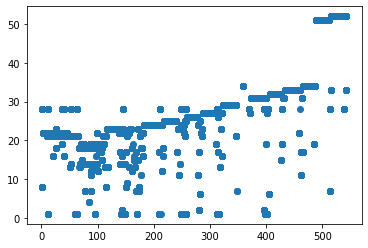

In [133]:
plt.scatter(x=df.unknown_1, y=df.unknown_2)

In [117]:
df[df.unknown_2.isna()==True]

,ts_date,ts_time,path,unknown_1,unknown_2,ip,timestamp,lvls,path0,path1,path2,path3,path4,path5,path6
idx,,,,,,,,,,,,,,,
2018-01-26 16:46:16,2018-01-26,16:46:16,/,48,NaN,97.105.19.61,2018-01-26 16:46:16,8,,,,,,,
2018-01-26 16:46:24,2018-01-26,16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,2018-01-26 16:46:24,8,spring,extra-features,form-validation,,,,
2018-01-26 17:54:24,2018-01-26,17:54:24,/,48,NaN,97.105.19.61,2018-01-26 17:54:24,8,,,,,,,
2018-01-26 18:32:03,2018-01-26,18:32:03,/,48,NaN,97.105.19.61,2018-01-26 18:32:03,8,,,,,,,
2018-01-26 18:32:17,2018-01-26,18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,2018-01-26 18:32:17,8,mysql,relationships,joins,,,,
2018-01-26 18:32:33,2018-01-26,18:32:33,mysql/tables,48,NaN,97.105.19.61,2018-01-26 18:32:33,8,mysql,tables,,,,,
2018-01-26 18:32:37,2018-01-26,18:32:37,mysql/databases,48,NaN,97.105.19.61,2018-01-26 18:32:37,8,mysql,databases,,,,,
2018-01-26 18:32:43,2018-01-26,18:32:43,mysql/relationships,48,NaN,97.105.19.61,2018-01-26 18:32:43,8,mysql,relationships,,,,,
2018-01-26 18:32:47,2018-01-26,18:32:47,mysql/relationships/joins,48,NaN,97.105.19.61,2018-01-26 18:32:47,8,mysql,relationships,joins,,,,


## Bonus:

Can you label students who are viewing both the web dev and data science curriculum? 
Can you label students by the program they are in? Can you label users by student vs. staff? 
What are Zach, Maggie, David, and Ryan's ids?